In [1]:
import numpy as np
import pickle
import os
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [2]:
# Define the root directory
name = 'Dataset-ppi--RE-True--W-True--Epochs-15000--D-8--RH-25--LR-0.1--LP-False--CUDA-True'
root = 'D:/study/thesis/project/HBDM-main/ppi_results/models/'+name
# W = True

# load data

## get hierarchical structure of level 1

In [3]:

# Specify the variable names
# variable_names = ['k_exp_dist','final_idx', 'general_cl_id', 'general_mask']
variable_names = ['k_exp_dist', 'general_cl_id', 'general_mask']
# Initialize a dictionary to store the loaded variables
loaded_variables = {}

# Loop through the variable names and load the data from pickle files
for var_name in variable_names:
    file_path = os.path.join(root, var_name + '.pkl')
    with open(file_path, 'rb') as f:
        loaded_data = pickle.load(f)
    loaded_variables[var_name] = loaded_data

# Access the loaded variables as needed
k_exp_dist = loaded_variables['k_exp_dist']
# final_idx = loaded_variables['final_idx']
general_cl_id = loaded_variables['general_cl_id']
general_mask = loaded_variables['general_mask']

### check data structure

In [4]:
k_exp_dist = np.array(k_exp_dist)
k_exp_dist.shape

(2078, 2078)

In [5]:
# check the cluster ids in different levels
for i in general_cl_id:
    a = list(set(i))
    print(a[0],a[-1])

0 9
10 29
30 69
70 149
150 297
512 511
564 983
984 1481
1482 1885
2048 2047
2052 2073
2074 2077


In [6]:
# check nodes in different levels, the position is map to general_cl_id cluster ids
for i in general_mask:
    a = list(set(i))
    print(max(a),min(a))

18766 0
18766 0
18766 0
18766 0
18766 0
18766 0
18766 0
18766 0
18766 0
18766 1
18696 108
18696 108


### take level 1 nodes

In [7]:
# check if the mask is ordered
if general_mask[0].tolist() != sorted(general_mask[0].tolist()):
    print('False')

In [8]:
# since the general_mask[0] is ordered, we can directly use list index as the node id
L1 = general_cl_id[0]
unique_values = np.unique(L1)
index_dict = {value: np.where(L1 == value)[0].tolist() for value in unique_values}

In [9]:
for key, value in index_dict.items():
    print(f"Key: {key}, Value Length: {len(value)}")

Key: 0, Value Length: 1182
Key: 1, Value Length: 2750
Key: 2, Value Length: 2983
Key: 3, Value Length: 2798
Key: 4, Value Length: 1100
Key: 5, Value Length: 3301
Key: 6, Value Length: 2374
Key: 7, Value Length: 750
Key: 8, Value Length: 571
Key: 9, Value Length: 958


### hierarchical structure of level 1

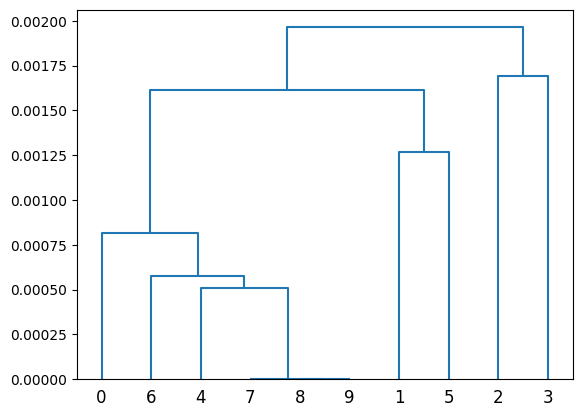

In [10]:

pltroot = 'D:/study/thesis/project/HBDM-main/ppi_results/plots/'

# Create your matrix of within-cluster Euclidean distances
distance_matrix = k_exp_dist[:10,:10]

# Perform hierarchical clustering
linkage_matrix = sch.linkage(distance_matrix, method='average')
dendrogram = sch.dendrogram(linkage_matrix, color_threshold=0)

# plt.title('Post-Processing Agglomerative Clustering Dendrogram')
# plt.xlabel('Clusters')
# plt.ylabel('Euclidean Distance')
# plt.savefig(pltroot+'Dendrogram-'+name+'.png')
# plt.show()

order = dendrogram['leaves']

In [11]:
order

[0, 6, 4, 7, 8, 9, 1, 5, 2, 3]

### get node order

In [12]:
index = []
for key in order:
    index.extend(index_dict[key])

In [13]:
len(index)

18767

## latent representation

In [14]:
### get node and 1d,2d

file_path_d = 'D:/study/thesis/project/HBDM-main/ppi_results/latent/'+name +'.pkl'
with open(file_path_d, 'rb') as file:
    loaded_tensor = pickle.load(file)

tensor = loaded_tensor.cpu()
node_rep = tensor.detach().numpy()


df_latent = pd.DataFrame()
for d in range(node_rep.shape[1]):
    col_name = str(d+1)+'d'
    df_latent[col_name] = node_rep.T[d]
df_latent['node'] = df_latent.index

In [15]:
## get node and cluster
clusters = []
ori_index = []
for key in index_dict:
    clusters += len(index_dict[key])*[int(key)]
    ori_index.extend(index_dict[key])
df = pd.DataFrame({'node': ori_index, 'cluster': clusters})

In [16]:
## get df: node, cluster, 1d, 2d
df = df.merge(df_latent)
df = df.sort_values(by='node')
df.head(5)

,node,cluster,1d,2d,3d,4d,5d,6d,7d,8d
14114,0,6,0.070718,-0.970324,-2.031606,-2.117536,-1.100787,1.924367,2.337702,-0.498431
3932,1,2,0.116251,-1.427020,-3.123650,-3.639700,-0.966149,3.426896,2.373441,-0.275181
10813,2,5,-0.670054,0.121622,-1.424834,-2.677057,0.615399,2.761855,0.771090,-0.155696
9713,3,4,2.386367,-6.904398,-2.759109,-2.735476,-3.104793,1.456720,1.598035,3.798105
14115,4,6,-1.241129,-0.937431,1.155136,-0.106069,-3.874555,-0.730731,4.720593,0.569784


# Test

## choose test dataset

In [17]:
with open(r'D:\study\thesis\project\HBDM-main\datasets\ppi\ppi_index.pkl', 'rb') as f:
    value_to_index_mapping = pickle.load(f)
with open(r'D:\study\thesis\project\HBDM-main\datasets\ppi\Aliases2stringId.pkl', 'rb') as f:
    ppi_name2stringId = pickle.load(f)

### from STRING-KEGG

In [18]:
# test_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\disease\CAD\KEGG Lipid and atherosclerosis.tsv',sep='\t')
# group = set(test_df['#node1'].unique())
# group.update(set(test_df['node2'].unique()))
# group = list(group)

# group_node = []
# for gene in group:
#     stringid = ppi_name2stringId[gene]
#     node = value_to_index_mapping[int(stringid[9:])]
#     group_node.append(node)

### from STRING cluster

In [19]:
# string_15942=pd.read_csv(r'D:\study\thesis\project\HBDM-main\string module\9606.clusters.proteins.v12.0.txt',sep='\t')
# string_15942 = string_15942[string_15942['cluster_id'] == 'CL:15942']
# group_node = []
# for i in string_15942['protein_id']:
#     node = value_to_index_mapping[int(i[9:])]
#     group_node.append(node)

### from DisGeNET disease

In [20]:
disease_df = pd.read_csv(r'D:\study\thesis\project\HBDM-main\disease\Crohn disease.tsv',sep='\t')

In [21]:
names = set(ppi_name2stringId.keys())
humans = set(value_to_index_mapping.keys())

group_node = []
for gene in disease_df['Gene']:
    if gene in names:
        stringid = ppi_name2stringId[gene]
        stringid = int(stringid[9:])
        if stringid in humans:
            node = value_to_index_mapping[stringid]
            group_node.append(node)

## label df with given group_node

### check label position in latent space

In [22]:
group_df = df[df['node'].isin(group_node)]
group_df['cluster'].unique()

array([5, 4, 2, 3, 1, 0, 7, 6, 8, 9], dtype=int64)

In [23]:
## get final df: node, cluster, 1d, 2d, label
df['label'] = df['node'].apply(lambda x: 1 if x in group_node else 0)
# Set the index to match the values in column 'node'
df = df.set_index('node')
# Reset the index to its default integer index
df = df.reset_index()

In [24]:
# # def show_positive(df):
# #     # Define the color map
# #     color_map = {0: 'grey', 1: 'red'}

# #     # Create a scatter plot
# #     plt.scatter(df['1d'], df['2d'], c=df['label'].map(color_map), s=0.1, label='Data Points')

# #     # Add labels
# #     plt.xlabel('1d')
# #     plt.ylabel('2d')


# #     # Set plot title
# #     plt.title('Scatter Plot of 1d vs. 2d')

# #     # Show the plot
# #     plt.grid(True)
# #     plt.savefig(pltroot+'positive-'+name+'.png')
# #     plt.show()

# %matplotlib widget

# # creating figure
# color_map = {0: 'grey', 1: 'red'}

# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# # creating the plot
# plot_geeks = ax.scatter(df['1d'], df['2d'], df['3d'], c=df['label'].map(color_map), s=0.1, label='Data Points')

# # setting title and labels
# ax.set_title("3D plot")
# ax.set_xlabel('x-axis')
# ax.set_ylabel('y-axis')
# ax.set_zlabel('z-axis')


# # displaying the plot
# plt.show()

In [25]:
# show_positive(df[(df['1d'] > -20) & (df['1d'] < 20) & (df['2d'] > -20) & (df['2d'] < 20)])
# show_positive(df)

## k nearest neighbor method

In [26]:
import random
from sklearn.neighbors import KDTree

### 5-fold corss validation get best K

In [27]:
output_file = 'D:/study/thesis/project/HBDM-main/ppi_results/test_results/CD/'+name+".txt"

In [28]:
df.head(3)

,node,cluster,1d,2d,3d,4d,5d,6d,7d,8d,label
0,0,6,0.070718,-0.970324,-2.031606,-2.117536,-1.100787,1.924367,2.337702,-0.498431,0
1,1,2,0.116251,-1.427020,-3.123650,-3.639700,-0.966149,3.426896,2.373441,-0.275181,0
2,2,5,-0.670054,0.121622,-1.424834,-2.677057,0.615399,2.761855,0.771090,-0.155696,1


In [29]:
from sklearn.model_selection import KFold

# Define your range of k values and leaf_size values
k_values = [2, 3, 4, 5, 6, 7, 8, 9]


# Split your data into 5 folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)
with open(output_file, "w") as f:
    for k in k_values:
        k+=1
        precision_scores = []
        coverage_scores = []
        random_precision_scores = []
        random_coverage_scores = []

        # Build a k-d tree from the points
        kdtree = KDTree(df[[col for col in df.columns if col.endswith('d')]].to_numpy(), leaf_size=20)
        for train_index, test_index in kf.split(group_node):
            train_nodes = [group_node[i] for i in train_index]
            test_nodes = [group_node[i] for i in test_index]

            start = []
            dist = []
            neighbor = []
            random_nodes = []
            for i in train_nodes:
                given_point = df[df['node']==i][[col for col in df.columns if col.endswith('d')]].to_numpy()
                # Perform a k-NN search to find the k+1 nearest neighbors
                distances, indices = kdtree.query(given_point, k=k)
                start += (k-1)*[i]
                dist += distances.reshape(-1).tolist()[1:]
                neighbor += indices.reshape(-1).tolist()[1:]

                random_nodes += random.sample(list(set(df['node'].tolist())-set(train_nodes)), (k-1))

            neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
            cover_df = neighbor_df[neighbor_df['neighbor'].isin(test_nodes)]
            
            # Append precision and coverage scores to lists
            precision_scores.append(len(cover_df) / len(neighbor_df))
            coverage_scores.append(len(cover_df['neighbor'].unique()) / len(test_nodes))
            
            ############################ random
            random_cover = []
            for j in random_nodes:
                if j in test_nodes:
                    random_cover.append(j)

            random_precision_scores.append(len(random_cover)/ len(random_nodes))
            random_coverage_scores.append(len(set(random_cover))/ len(test_nodes))

        ###### choose one fold to check details
        ranked = neighbor_df.sort_values(by='distance')
        coverage = 0
        for top_threshold in range(50, len(neighbor_df), 50):
            cover = []
            top_recommend = ranked['neighbor'].tolist()[:top_threshold]
            for i in top_recommend: 
                if i in test_nodes:
                    cover.append(i)
            if len(set(cover)) / len(test_nodes) > coverage:
                coverage = len(set(cover)) / len(test_nodes)
                top_precision = len(cover) / top_threshold
                print(f'top {top_threshold} precision: {top_precision}', file=f)
                print(f'top {top_threshold} coverage: {coverage}', file=f)
            else:
                print('coverage limitation', file=f)
                break
        # Calculate the average precision and coverage scores for the current k and leaf_size
        avg_precision = sum(precision_scores) / len(precision_scores)
        avg_coverage = sum(coverage_scores) / len(coverage_scores)

        random_avg_precision = sum(random_precision_scores) / len(random_precision_scores)
        random_avg_coverage = sum(random_coverage_scores) / len(random_coverage_scores)
        
        print(f"k={k-1}, leaf_size={20}",'\t',"Average Precision:", avg_precision,'\t',"Average Coverage:", avg_coverage)
        result_line = f"k={k-1}, leaf_size={20}\tAverage Precision: {avg_precision}\tAverage Coverage: {avg_coverage}\n"
        print(f"k={k-1}, leaf_size={20}\tRandom Precision: {random_avg_precision}\tRandom Coverage: {random_avg_coverage}", file=f)
        f.write(result_line)


k=2, leaf_size=20 	 Average Precision: 0.04355332904372338 	 Average Coverage: 0.24980083583648946
k=3, leaf_size=20 	 Average Precision: 0.04264396577844505 	 Average Coverage: 0.3168865090766619
k=4, leaf_size=20 	 Average Precision: 0.04264459560212846 	 Average Coverage: 0.3831559357450699
k=5, leaf_size=20 	 Average Precision: 0.04304864621952589 	 Average Coverage: 0.44216403291106177
k=6, leaf_size=20 	 Average Precision: 0.042542921632911526 	 Average Coverage: 0.4874395977536895
k=7, leaf_size=20 	 Average Precision: 0.04261511547659171 	 Average Coverage: 0.5343150058769753
k=8, leaf_size=20 	 Average Precision: 0.04213860036155284 	 Average Coverage: 0.5618029254277132
k=9, leaf_size=20 	 Average Precision: 0.04172360613209956 	 Average Coverage: 0.5909135431631187


In [30]:
# k=9
# num_to_test = int(len(group_node) * 0.8)

# start_nodes = random.sample(group_node, num_to_test)
# test_nodes =  list(set(group_node) - set(start_nodes))

# # Build a k-d tree from the points
# kdtree = KDTree(df[['1d', '2d']].to_numpy(), leaf_size=20)
# k+=1
# start = []
# dist = []
# neighbor = []
# for i in start_nodes:
#     given_point = df[df['node']==i][['1d', '2d']].to_numpy()
#     # Perform a k-NN search to find the k+1 nearest neighbors
#     distances, indices = kdtree.query(given_point, k=k)
#     start += (k-1)*[i]
#     dist += distances.reshape(-1).tolist()[1:]
#     neighbor += indices.reshape(-1).tolist()[1:]

# neighbor_df = pd.DataFrame({'start': start, 'neighbor': neighbor, 'distance': dist})
# cover_df = neighbor_df[neighbor_df['neighbor'].isin(test_nodes)]

# print(k-1,' precision: ',len(cover_df)/len(neighbor_df))
# print(k-1,' coverage: ',len(cover_df['neighbor'].unique())/len(test_nodes))

In [31]:
len(set(ranked['neighbor'].tolist()[:50]))

50

In [32]:
len(set(ranked['neighbor'].tolist()[:50])&set(test_nodes))

1

In [33]:
len(test_nodes)

247

In [34]:
len(neighbor_df)

8910

In [35]:
ranked

,start,neighbor,distance
6219,14897,11852,0.003272
7677,5090,5002,0.003897
7686,5002,5090,0.003897
6615,6508,8414,0.004191
7659,5083,1013,0.005029
...,...,...,...
5323,2076,16647,4.902426
5324,2076,11440,5.317261
5325,2076,17465,5.416301
5326,2076,3399,5.494848


## PU classifier

In [36]:
# X = df[['1d', '2d']].to_numpy()
# y = df['label'].to_numpy()

In [37]:
# from pulearn import WeightedElkanotoPuClassifier
# from sklearn.svm import SVC
# from sklearn.metrics import precision_recall_fscore_support
# from sklearn.model_selection import StratifiedKFold

# svc = SVC(C=10, kernel='rbf', gamma=0.4, probability=True)
# pu_estimator = WeightedElkanotoPuClassifier(
#     estimator=svc, labeled=10, unlabeled=20, hold_out_ratio=0.2)


# # Initialize stratified k-fold cross-validation
# kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Lists to store cross-validation scores
# pu_f1_scores = []

# # Perform cross-validation
# for train_index, test_index in kf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     pu_estimator.fit(X_train, y_train)
#     y_pred = pu_estimator.predict(X_test)
#     precision, recall, f1_score, _ = precision_recall_fscore_support(
#         y_test, y_pred)
#     pu_f1_scores.append(f1_score[1])
#     print("F1 score: {}".format(f1_score[1]))
#     print("Precision: {}".format(precision[1]))
#     print("Recall: {}".format(recall[1]))

# plt.plot(pu_f1_scores, label='PU')

